<a href="https://colab.research.google.com/github/sgcortes/25ForageYieldNWSpain/blob/main/V7_UFL_RFR_LGBM_XGB_OPTUNA_SHAP_PERMU_kgDM_RAD_Dia_Export.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📚 Regression Models Comparation (LightGBM, XGBoost. Adaboost, Random Forest Regressor. Hyperparameter Tuning with Optuna on best models)

Training and evaluation of 4 basic regression models and additional Hyperparameter optimization with Optuna for LightGBM,XGBoost and RFR.
The last one does not improve metrics with respect to the basic model.

 + LightGBM and XGBoost use categorical variables natively (no codification),
 + Random Forest Regressor and AdaBoost use onehot encoder.
 + No normalization on variable values (e.g. no standarization. This is not needed with ensemble models based on decision trees)
 + Radiation diary mean values (no acumulated radiation values during all the growing season).


In [6]:
!pip show lightgbm | pip install lightgbm==4.6.0

In [7]:
# 🔧 Instalación de librerías necesarias
try:
    import optuna
    import lightgbm
    import xgboost
    import shap
    import openpyxl
    import joblib
except ImportError:
    !pip install -q optuna lightgbm xgboost shap scikit-learn openpyxl


In [8]:
# 📦 Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import optuna
import shap
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [9]:
# 📂 Cargar datos
file_path = (r"C:\Users\hamza\Downloads\260324_ENG_MaizeForageSpainNWwtYearRadDay.xlsx")
df = pd.read_excel(file_path)

In [10]:
# 🎯 Selección de variable objetivo
print("Variables disponibles: ['kgDM/ha', 'kgCP/ha', 'UFL/ha']")
objective_var = 'UFL/ha'

Variables disponibles: ['kgDM/ha', 'kgCP/ha', 'UFL/ha']


In [11]:
# Variables
categorical_features = ['Site', 'Cultivar']


y = df[objective_var]
X = df.drop(columns=['kgDM/ha', 'kgCP/ha', 'UFL/ha'])
# Convertir las columnas categóricas a 'category'
for col in categorical_features:
    X[col] = X[col].astype('category')

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##
print(X.columns,"\n")
#print(X.head)

Index(['Site', 'Cultivar', 'Elevation(m)', 'Radiation(Mj/m2day)',
       'Precipitation(mm)', 'Tmax(ºC)', 'Tmin(ºC)', 'WHC(mm)', 'C(%)', 'pH',
       'SowingDate(doy)', 'AnthesisDate(doy)', 'HarvestDate(doy)',
       'GrowingSeason(day)'],
      dtype='object') 



# 🔵 Basic Model  Training (no hyperparameter optimization). LightGBM, XGBoost, Adaboost and Random Forest Regressors.  

In [13]:
# LightGBM básico
lgb_basic = lgb.LGBMRegressor(categorical_feature=categorical_features)
lgb_basic.fit(X_train, y_train)
y_pred_lgb_basic = lgb_basic.predict(X_test)

# XGBoost básico
xgb_basic = xgb.XGBRegressor(enable_categorical=True, tree_method='hist')
xgb_basic.fit(X_train, y_train)
y_pred_xgb_basic = xgb_basic.predict(X_test)

# One-hot encoding para AdaBoost y Random Forest
X_encoded = pd.get_dummies(X, columns=categorical_features)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 🔸 AdaBoost Regressor (modelo base: DecisionTree)
adaboost_model = AdaBoostRegressor(random_state=42)
adaboost_model.fit(X_train_enc, y_train_enc)
y_pred_adaboost = adaboost_model.predict(X_test_enc)

# 🔸 Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_enc, y_train_enc)
y_pred_rf = rf_model.predict(X_test_enc)

C:\Users\hamza\anaconda3\Lib\site-packages\lightgbm\basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
C:\Users\hamza\anaconda3\Lib\site-packages\lightgbm\basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] categorical_feature is set=Site,Cultivar, categorical_column=0,1 will be ignored. Current value: categorical_feature=Site,Cultivar
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 1159, number of used features: 14
[LightGBM] [Info] Start training from score 15307.825496


# 📈 Basic Models Evaluation

In [15]:
def evaluate(y_true, y_pred, name="Modelo"):
    print(f"\n{name}")
    print("R2:", r2_score(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("MAPE:", np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

evaluate(y_test, y_pred_lgb_basic, name="LightGBM Basic")
evaluate(y_test, y_pred_xgb_basic, name="XGBoost Basic")
evaluate(y_test, y_pred_adaboost, name="AdaBoost Basic")
evaluate(y_test, y_pred_rf, name="Random Forest Basic")


LightGBM Basic
R2: 0.834738630440265
RMSE: 1203.9624360443177
MAE: 910.5409841799619
MAPE: 5.969446522380431

XGBoost Basic
R2: 0.8234331847321763
RMSE: 1244.4624736056649
MAE: 923.7873215247845
MAPE: 6.027205195179914

AdaBoost Basic
R2: 0.7312399024222449
RMSE: 1535.3580073500789
MAE: 1186.118961339117
MAPE: 8.000910800315165

Random Forest Basic
R2: 0.8374702255612887
RMSE: 1193.9708655736695
MAE: 899.4818224137935
MAPE: 5.904722144497695


### Variable importance for RMS global reduction

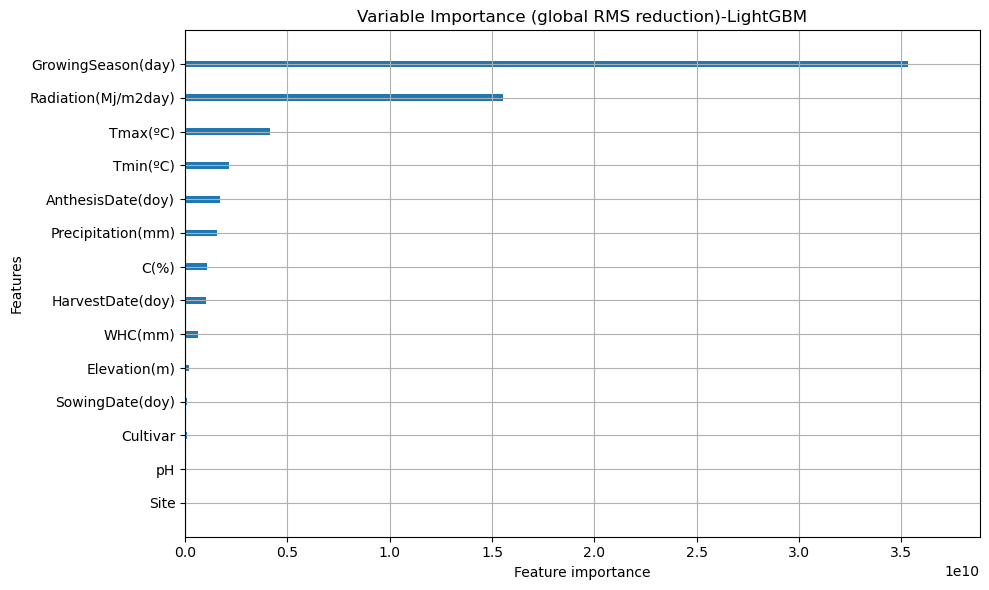

In [20]:
# Asumiendo que lgb_model ya está entrenado
booster = lgb_basic.booster_  # Extrae el booster del modelo sklearn

ax = lgb.plot_importance(booster, max_num_features=15, importance_type='gain', figsize=(10, 6))
# Eliminar los valores numéricos que aparecen en las barras
for text in ax.texts:
    text.set_visible(False)
plt.title("Variable Importance (global RMS reduction)-LightGBM")
plt.tight_layout()
plt.show()

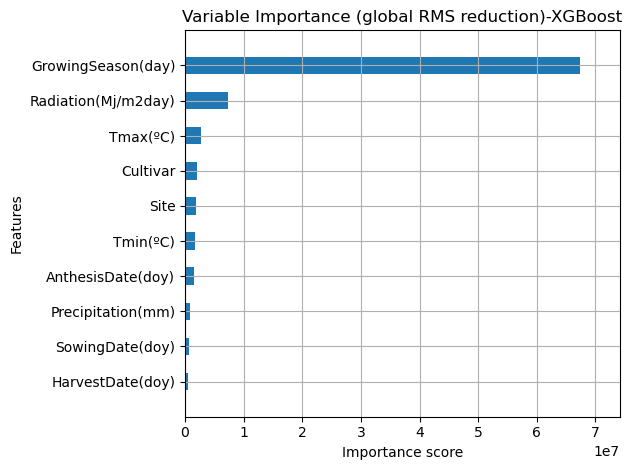

In [21]:
xgb.plot_importance(
    xgb_basic,
    importance_type='gain',   # 'gain' mide cuánto mejora la predicción una variable (puedes usar 'weight' o 'cover' también)
    max_num_features=20,      # mostrar solo las 15 más importantes
    height=0.5,               # altura de las barras
    show_values=False         # si quieres que no ponga los números al lado
)

plt.title('Variable Importance (global RMS reduction)-XGBoost')
plt.tight_layout()
plt.show()

### Variable importance for RMS reduction with Adaboost and Random Forest Regressor

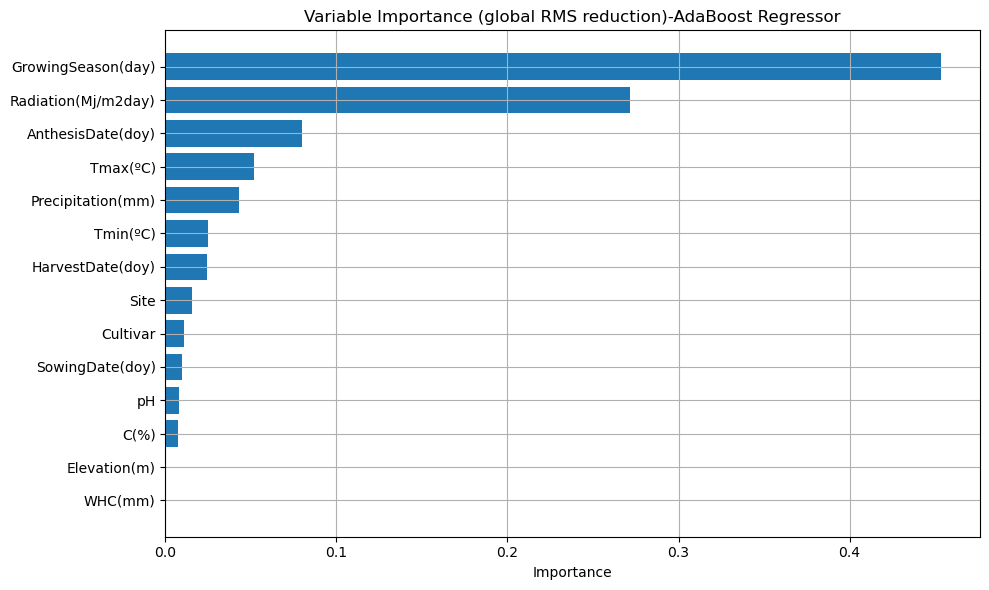

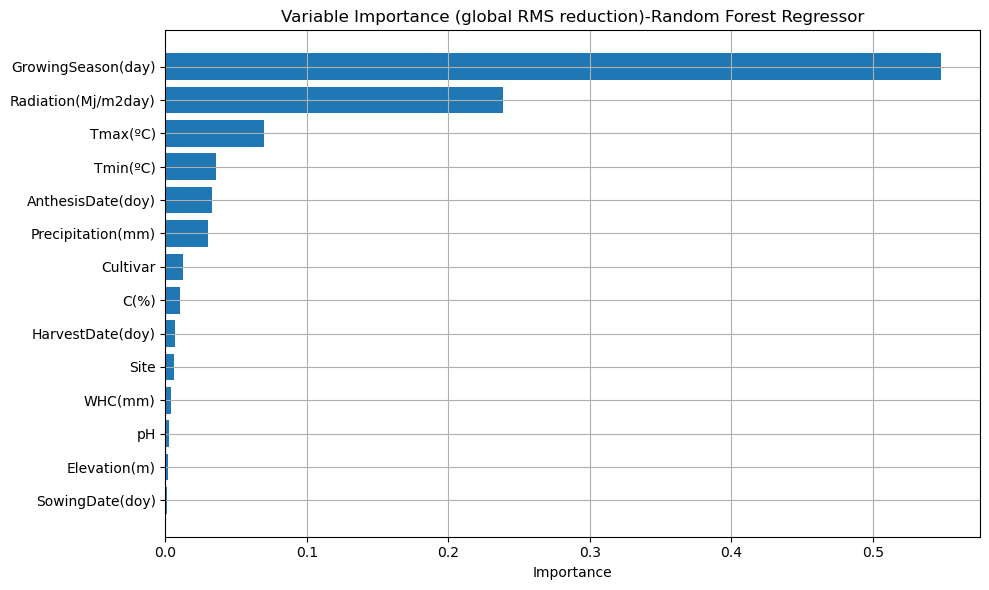

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Obtener nombres de las características
feature_names = X_train_enc.columns if hasattr(X_train_enc, 'columns') else [f'Feature_{i}' for i in range(X_train_enc.shape[1])]

def agrupar_importancias(importances, feature_names):
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

    # Agrupar variables por prefijo (antes del "_") o quedarse con el nombre si no hay "_"
    def agrupar_nombre(col):
        if '_' in col:
            return col.split('_')[0]  # e.g., Cultivar_200 → Cultivar
        else:
            return col

    importance_df['grupo'] = importance_df['feature'].apply(agrupar_nombre)
    grouped = importance_df.groupby('grupo', as_index=False)['importance'].sum()

    # Orden descendente por importancia
    grouped_sorted = grouped.sort_values(by='importance', ascending=True)

    return grouped_sorted

def plot_feature_importances_grouped(importances, model_name):
    grouped_df = agrupar_importancias(importances, feature_names)

    plt.figure(figsize=(10, 6))
    plt.barh(grouped_df['grupo'], grouped_df['importance'])
    plt.xlabel('Importance')
    plt.title(f'Variable Importance (global RMS reduction)-{model_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 🔹 AdaBoost
plot_feature_importances_grouped(adaboost_model.feature_importances_, 'AdaBoost Regressor')

# 🔸 Random Forest
plot_feature_importances_grouped(rf_model.feature_importances_, 'Random Forest Regressor')


# 🧪 Hyperparameter Optimization with Optuna

In [28]:
def objective_lgb(trial):
    params = {
        'objective': 'regression',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42
    }
    model = lgb.LGBMRegressor(**params)
    score = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()
    return -score

def objective_xgb(trial):
    params = {
        'objective': 'reg:squarederror',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'tree_method': 'hist',
        'enable_categorical': True,
        'random_state': 42
    }
    model = xgb.XGBRegressor(**params)
    score = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()
    return -score

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestRegressor(**params)
    score = cross_val_score(model, X_train_enc, y_train_enc, cv=5, scoring='r2', n_jobs=-1).mean()
    return score


study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=30)

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=30)

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=30)


[I 2025-08-15 23:22:01,094] A new study created in memory with name: no-name-9ce11264-0f2a-4bce-9527-864c4dcc8590


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 15344.879593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-08-15 23:22:01,380] Trial 0 finished with value: 1197.5826502609539 and parameters: {'learning_rate': 0.1356241316314165, 'num_leaves': 156, 'max_depth': 3, 'min_child_samples': 19, 'subsample': 0.5376363923605876, 'colsample_bytree': 0.8858730904271358}. Best is trial 0 with value: 1197.5826502609539.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 23:22:01,640] Trial 1 finished with value: 1229.36852510764 and parameters: {'learning_rate': 0.20633771064538153, 'num_leaves': 199, 'max_depth': 7, 'min_child_samples': 56, 'subsample': 0.7067494285539474, 'colsample_bytree': 0.5469052327575212}. Best is trial 0 with value: 1197.5826502609539.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 23:22:01,818] Trial 2 finished with value: 1331.6718319737383 and parameters: {'learning_rate': 0.09076811538965542, 'num_leaves': 91, 'max_depth': 14, 'min_child_samples': 98, 'subsample': 0.5757484921025837, 'colsample_bytree': 0.8576171131920983}. Best is trial 0 with value: 1197.5826502609539.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 15323.071582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-08-15 23:22:01,991] Trial 3 finished with value: 1321.3873016995085 and parameters: {'learning_rate': 0.08344553776873886, 'num_leaves': 96, 'max_depth': 6, 'min_child_samples': 87, 'subsample': 0.773258828914734, 'colsample_bytree': 0.9116398683486231}. Best is trial 0 with value: 1197.5826502609539.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 14
[LightGBM] [Info] Start training from score 15270.718054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-08-15 23:22:02,193] Trial 4 finished with value: 1419.592977895973 and parameters: {'learning_rate': 0.023981616761649845, 'num_leaves': 135, 'max_depth': 9, 'min_child_samples': 50, 'subsample': 0.5922684807301379, 'colsample_bytree': 0.9362378682172641}. Best is trial 0 with value: 1197.5826502609539.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 23:22:02,383] Trial 5 finished with value: 1256.3511164443814 and parameters: {'learning_rate': 0.24362664901360165, 'num_leaves': 137, 'max_depth': 7, 'min_child_samples': 45, 'subsample': 0.735315803157281, 'colsample_bytree': 0.9619893994228579}. Best is trial 0 with value: 1197.5826502609539.
[I 2025-08-15 23:22:02,533] Trial 6 finished with value: 1265.2910207177424 and parameters: {'learning_rate': 0.11641328072230872, 'num_leaves': 30, 'max_depth': 4, 'min_child_samples': 69, 'subsample': 0.5621004537397686, 'colsample_bytree': 0.656174875884858}. Best is trial 0 with value: 1197.5826502609539.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 15344.879593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-08-15 23:22:02,724] Trial 7 finished with value: 1205.3426305784708 and parameters: {'learning_rate': 0.11163225010016166, 'num_leaves': 102, 'max_depth': 3, 'min_child_samples': 16, 'subsample': 0.8301064109570964, 'colsample_bytree': 0.5483468572033954}. Best is trial 0 with value: 1197.5826502609539.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 23:22:03,010] Trial 8 finished with value: 1203.4128096499403 and parameters: {'learning_rate': 0.25875149484592597, 'num_leaves': 23, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.5226506883281152, 'colsample_bytree': 0.5431088534495934}. Best is trial 0 with value: 1197.5826502609539.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 15281.545695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-08-15 23:22:03,540] Trial 9 finished with value: 1227.8157474149834 and parameters: {'learning_rate': 0.2557461485977943, 'num_leaves': 118, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.9456086799560873, 'colsample_bytree': 0.8876092237852824}. Best is trial 0 with value: 1197.5826502609539.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 14
[LightGBM] [Info] Start training from score 15270.718054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-08-15 23:22:03,824] Trial 10 finished with value: 1192.160946071889 and parameters: {'learning_rate': 0.17702502820661625, 'num_leaves': 179, 'max_depth': 5, 'min_child_samples': 31, 'subsample': 0.663613821627618, 'colsample_bytree': 0.7358970239541739}. Best is trial 10 with value: 1192.160946071889.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 15318.952586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-08-15 23:22:04,079] Trial 11 finished with value: 1189.2776946409272 and parameters: {'learning_rate': 0.18047607062222498, 'num_leaves': 187, 'max_depth': 5, 'min_child_samples': 32, 'subsample': 0.6527802416275394, 'colsample_bytree': 0.7685675154658881}. Best is trial 11 with value: 1189.2776946409272.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 15344.879593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-08-15 23:22:04,452] Trial 12 finished with value: 1202.2936628447792 and parameters: {'learning_rate': 0.18763002177825813, 'num_leaves': 192, 'max_depth': 5, 'min_child_samples': 34, 'subsample': 0.6520390675406093, 'colsample_bytree': 0.751615265141074}. Best is trial 11 with value: 1189.2776946409272.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 23:22:04,889] Trial 13 finished with value: 1186.9989680069627 and parameters: {'learning_rate': 0.18423101548560067, 'num_leaves': 170, 'max_depth': 8, 'min_child_samples': 35, 'subsample': 0.6549336612102723, 'colsample_bytree': 0.7563702048316826}. Best is trial 13 with value: 1186.9989680069627.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 23:22:05,355] Trial 14 finished with value: 1226.786145033214 and parameters: {'learning_rate': 0.2988660704741085, 'num_leaves': 171, 'max_depth': 8, 'min_child_samples': 35, 'subsample': 0.8312137103304313, 'colsample_bytree': 0.7863334843015716}. Best is trial 13 with value: 1186.9989680069627.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 23:22:05,607] Trial 15 finished with value: 1262.1062764799829 and parameters: {'learning_rate': 0.1590890380525006, 'num_leaves': 62, 'max_depth': 11, 'min_child_samples': 66, 'subsample': 0.6354062526460736, 'colsample_bytree': 0.6813233952394294}. Best is trial 13 with value: 1186.9989680069627.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 15344.879593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-08-15 23:22:06,040] Trial 16 finished with value: 1231.393197966524 and parameters: {'learning_rate': 0.21089200934831057, 'num_leaves': 159, 'max_depth': 9, 'min_child_samples': 42, 'subsample': 0.7922002132238488, 'colsample_bytree': 0.8138440801898281}. Best is trial 13 with value: 1186.9989680069627.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 15323.071582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-08-15 23:22:06,567] Trial 17 finished with value: 1182.356782193849 and parameters: {'learning_rate': 0.040396147328307555, 'num_leaves': 152, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.9245199397566711, 'colsample_bytree': 0.6482211811544519}. Best is trial 17 with value: 1182.356782193849.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 23:22:07,613] Trial 18 finished with value: 1235.726246082667 and parameters: {'learning_rate': 0.025542163657528982, 'num_leaves': 146, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.981422633364807, 'colsample_bytree': 0.641622904175952}. Best is trial 17 with value: 1182.356782193849.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 23:22:08,656] Trial 19 finished with value: 1192.705331993544 and parameters: {'learning_rate': 0.06369437225642123, 'num_leaves': 123, 'max_depth': 15, 'min_child_samples': 6, 'subsample': 0.8784184071637973, 'colsample_bytree': 0.5974406670664776}. Best is trial 17 with value: 1182.356782193849.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 23:22:08,953] Trial 20 finished with value: 1302.919368927415 and parameters: {'learning_rate': 0.05090259346596987, 'num_leaves': 166, 'max_depth': 7, 'min_child_samples': 63, 'subsample': 0.9101382827087967, 'colsample_bytree': 0.7045645989005118}. Best is trial 17 with value: 1182.356782193849.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 14
[LightGBM] [Info] Start training from score 15270.718054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-08-15 23:22:09,243] Trial 21 finished with value: 1166.3910313189253 and parameters: {'learning_rate': 0.13768585789883853, 'num_leaves': 183, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.6925208407598329, 'colsample_bytree': 0.8074664481372033}. Best is trial 21 with value: 1166.3910313189253.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 23:22:09,531] Trial 22 finished with value: 1175.0322697499946 and parameters: {'learning_rate': 0.1441431506080697, 'num_leaves': 180, 'max_depth': 6, 'min_child_samples': 26, 'subsample': 0.686075291427967, 'colsample_bytree': 0.8114947538928283}. Best is trial 21 with value: 1166.3910313189253.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 15344.879593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-08-15 23:22:09,843] Trial 23 finished with value: 1196.6326274527216 and parameters: {'learning_rate': 0.13675655480898735, 'num_leaves': 182, 'max_depth': 6, 'min_child_samples': 24, 'subsample': 0.7183494430140586, 'colsample_bytree': 0.8290613443314649}. Best is trial 21 with value: 1166.3910313189253.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 23:22:10,093] Trial 24 finished with value: 1234.2793323547062 and parameters: {'learning_rate': 0.05328657267564048, 'num_leaves': 199, 'max_depth': 4, 'min_child_samples': 24, 'subsample': 0.7049966875206433, 'colsample_bytree': 0.7111448997481272}. Best is trial 21 with value: 1166.3910313189253.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 23:22:10,466] Trial 25 finished with value: 1177.4476808928623 and parameters: {'learning_rate': 0.14184611452305762, 'num_leaves': 147, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.8096422727572594, 'colsample_bytree': 0.6103165264699802}. Best is trial 21 with value: 1166.3910313189253.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 14
[LightGBM] [Info] Start training from score 15270.718054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-08-15 23:22:11,123] Trial 26 finished with value: 1171.373202574347 and parameters: {'learning_rate': 0.14878274175932327, 'num_leaves': 137, 'max_depth': 4, 'min_child_samples': 15, 'subsample': 0.8072340167824265, 'colsample_bytree': 0.5965164082217169}. Best is trial 21 with value: 1166.3910313189253.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 23:22:11,542] Trial 27 finished with value: 1199.1573254720283 and parameters: {'learning_rate': 0.10591964818099431, 'num_leaves': 127, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.7635406881077549, 'colsample_bytree': 0.822199463929463}. Best is trial 21 with value: 1166.3910313189253.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 23:22:11,898] Trial 28 finished with value: 1256.9955141668277 and parameters: {'learning_rate': 0.15834301822214228, 'num_leaves': 82, 'max_depth': 3, 'min_child_samples': 42, 'subsample': 0.6889443596222308, 'colsample_bytree': 0.9824657049619452}. Best is trial 21 with value: 1166.3910313189253.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 14
[LightGBM] [Info] Start training from score 15270.718054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-08-15 23:22:12,222] Trial 29 finished with value: 1203.9435283617318 and parameters: {'learning_rate': 0.12752387799305595, 'num_leaves': 161, 'max_depth': 3, 'min_child_samples': 18, 'subsample': 0.611783178850068, 'colsample_bytree': 0.5001488902313587}. Best is trial 21 with value: 1166.3910313189253.
[I 2025-08-15 23:22:12,224] A new study created in memory with name: no-name-12e5f5b1-018e-4b7e-bd40-b91b62984d06


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 15281.545695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-08-15 23:22:17,775] Trial 0 finished with value: 1170.7171823446056 and parameters: {'learning_rate': 0.06462902008548085, 'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.9611338275035186, 'colsample_bytree': 0.866903059951496}. Best is trial 0 with value: 1170.7171823446056.
[I 2025-08-15 23:22:19,524] Trial 1 finished with value: 1180.1044313402367 and parameters: {'learning_rate': 0.08059421772072853, 'max_depth': 11, 'min_child_weight': 4, 'subsample': 0.9306657215176264, 'colsample_bytree': 0.91674107442173}. Best is trial 0 with value: 1170.7171823446056.
[I 2025-08-15 23:22:20,128] Trial 2 finished with value: 1175.844710753767 and parameters: {'learning_rate': 0.18717064276030146, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.6338859247519659, 'colsample_bytree': 0.7931592715198637}. Best is trial 0 with value: 1170.7171823446056.
[I 2025-08-15 23:22:21,452] Trial 3 finished with value: 1162.33283298988 and parameters: {'learning_rate': 0.1076296611955800

# 🚀 Regressors Training on Optimized Models

In [30]:
lgb_best = lgb.LGBMRegressor(**study_lgb.best_params, categorical_feature=categorical_features)
lgb_best.fit(X_train, y_train)
y_pred_lgb_best = lgb_best.predict(X_test)

xgb_best = xgb.XGBRegressor(**study_xgb.best_params, enable_categorical=True, tree_method='hist')
xgb_best.fit(X_train, y_train)
y_pred_xgb_best = xgb_best.predict(X_test)

# Entrenar modelo con mejores hiperparámetros
rf_best = RandomForestRegressor(**study_rf.best_params)
rf_best.fit(X_train_enc, y_train_enc)
y_pred_rf_best = rf_best.predict(X_test_enc)

evaluate(y_test, y_pred_lgb_best, name="LightGBM Optuna")
evaluate(y_test, y_pred_xgb_best, name="XGBoost Optuna")
evaluate(y_test, y_pred_rf_best, name="RFR Optuna")

C:\Users\hamza\anaconda3\Lib\site-packages\lightgbm\basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
C:\Users\hamza\anaconda3\Lib\site-packages\lightgbm\basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] categorical_feature is set=Site,Cultivar, categorical_column=0,1 will be ignored. Current value: categorical_feature=Site,Cultivar
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 1159, number of used features: 14
[LightGBM] [Info] Start training from score 15307.825496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

### Global Variable importance for Optimized Regressors (XGBoost and LightGBM)

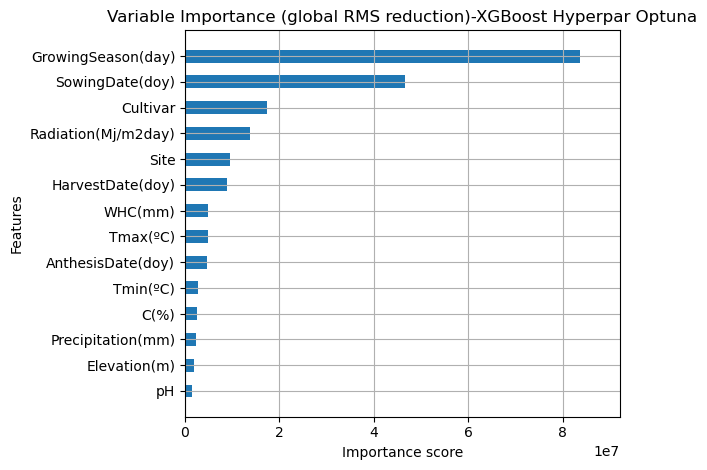

In [32]:
xgb.plot_importance(
    xgb_best,
    importance_type='gain',   # 'gain' mide cuánto mejora la predicción una variable (puedes usar 'weight' o 'cover' también)
    max_num_features=20,      # mostrar solo las 15 más importantes
    height=0.5,               # altura de las barras
    show_values=False         # si quieres que no ponga los números al lado
)

plt.title('Variable Importance (global RMS reduction)-XGBoost Hyperpar Optuna')
plt.tight_layout()
plt.show()

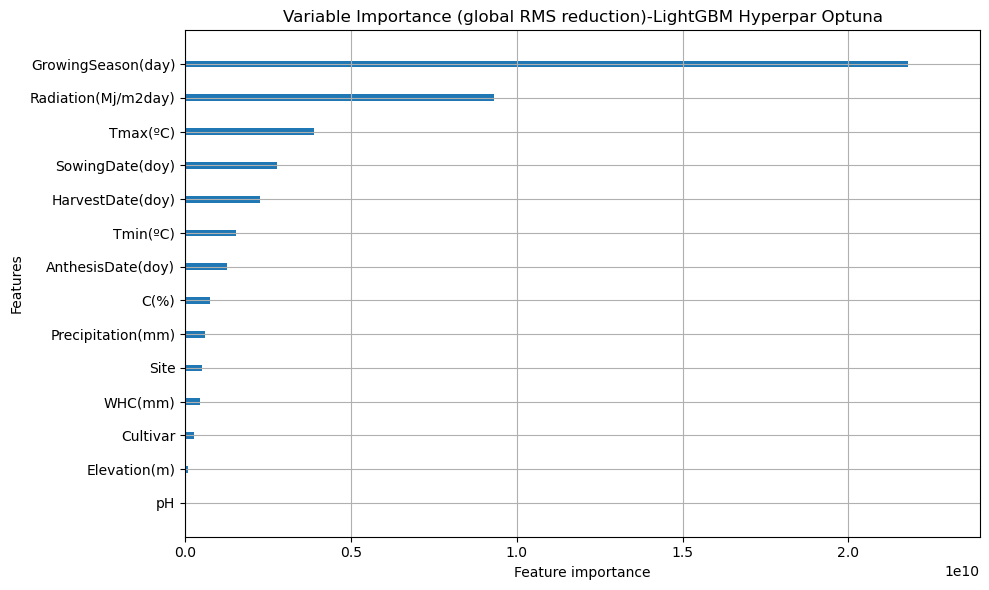

In [33]:
booster = lgb_best.booster_  # Extrae el booster del modelo sklearn

ax = lgb.plot_importance(booster, max_num_features=15, importance_type='gain', figsize=(10, 6))
# Eliminar los valores numéricos que aparecen en las barras
for text in ax.texts:
    text.set_visible(False)
plt.title('Variable Importance (global RMS reduction)-LightGBM Hyperpar Optuna')
plt.tight_layout()
plt.show()

### Variable permutation  Tests

📊 Test de Permutación - LightGBM Optuna


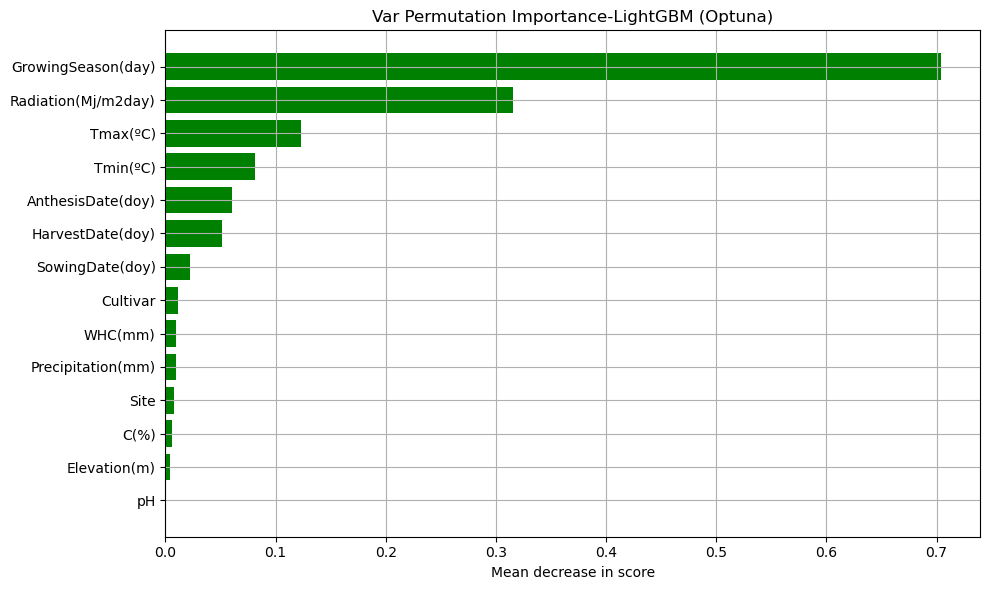

Var Permutation Importance-XGBoost (Optuna)


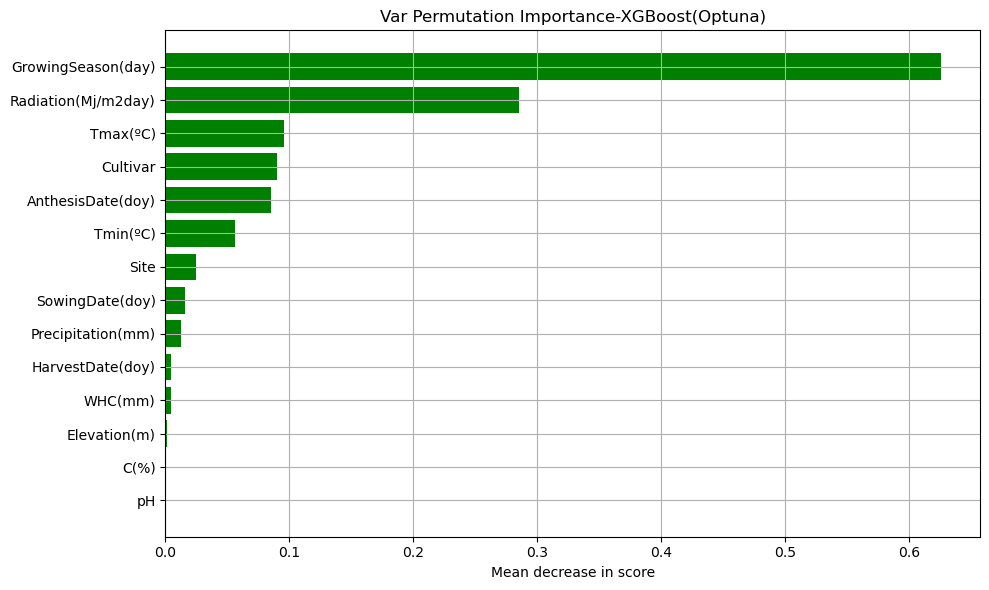

In [35]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Test de permutación para LightGBM optimizado
print("📊 Test de Permutación - LightGBM Optuna")
perm_lgb = permutation_importance(
    lgb_best, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

# Ordenar variables de mayor a menor importancia
sorted_idx = perm_lgb.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X_test.columns[sorted_idx], perm_lgb.importances_mean[sorted_idx],color='green')
plt.title("Var Permutation Importance-LightGBM (Optuna)")
plt.xlabel("Mean decrease in score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Test de permutación para XGBoost optimizado
print("Var Permutation Importance-XGBoost (Optuna)")
perm_xgb = permutation_importance(
    xgb_best, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

# Ordenar variables de mayor a menor importancia
sorted_idx = perm_xgb.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X_test.columns[sorted_idx], perm_xgb.importances_mean[sorted_idx],color='green')
plt.title("Var Permutation Importance-XGBoost(Optuna)")
plt.xlabel("Mean decrease in score")
plt.grid(True)
plt.tight_layout()
plt.show()


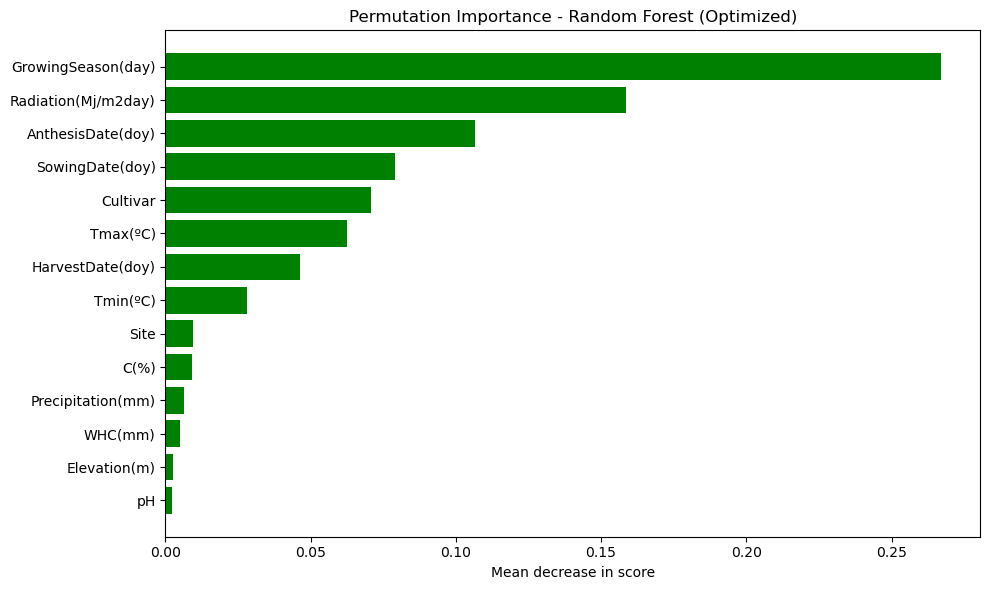

In [36]:

# 📊 Permutation importance - Random Forest (optimized)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

perm_rf = permutation_importance(rf_best, X_test_enc, y_test_enc, n_repeats=10, random_state=42, n_jobs=-1)
importances_rf = perm_rf.importances_mean

# Agrupar por variable base (si es one-hot)
def agrupar_importancias(importances, feature_names):
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    importance_df['grupo'] = importance_df['feature'].apply(lambda x: x.split('_')[0] if '_' in x else x)
    return importance_df.groupby('grupo', as_index=False)['importance'].sum().sort_values(by='importance', ascending=True)

feature_names = X_train_enc.columns if hasattr(X_train_enc, 'columns') else [f"Feature_{i}" for i in range(X_train_enc.shape[1])]
df_rf_perm = agrupar_importancias(importances_rf, feature_names)

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(df_rf_perm['grupo'], df_rf_perm['importance'],color='green')
plt.title("Permutation Importance - Random Forest (Optimized)")
plt.xlabel("Mean decrease in score")
plt.tight_layout()
plt.show()


### SHAP Values

📌 SHAP Values for Optimized LightGBM



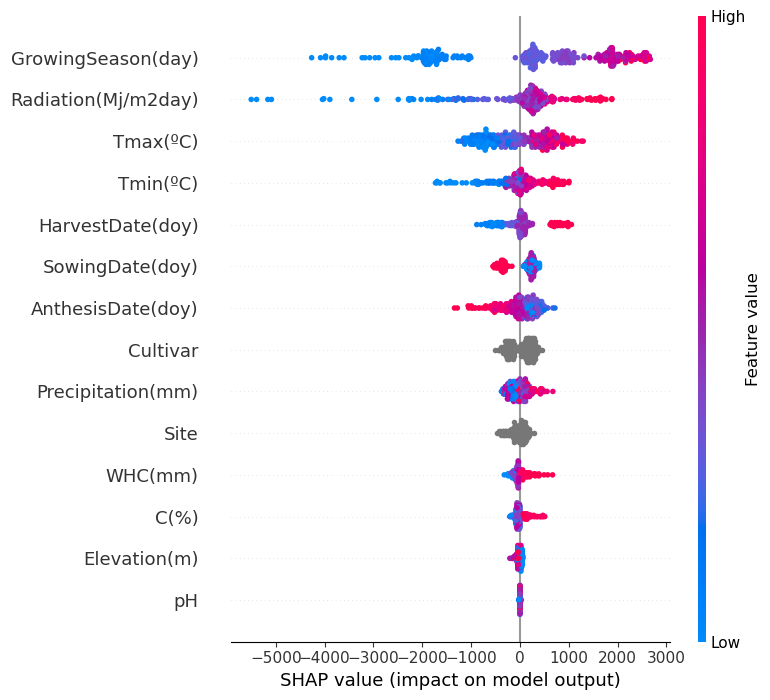

In [41]:
# 🔍 Calcular y visualizar SHAP values para LightGBM
import shap
shap.initjs()

# TreeExplainer para modelos basados en árboles como LightGBM
explainer_lgb = shap.TreeExplainer(lgb_best)
shap_values_lgb = explainer_lgb.shap_values(X_test)

# Gráfico resumen
shap.summary_plot(shap_values_lgb, X_test)

📌 SHAP for Optmized XGBoost

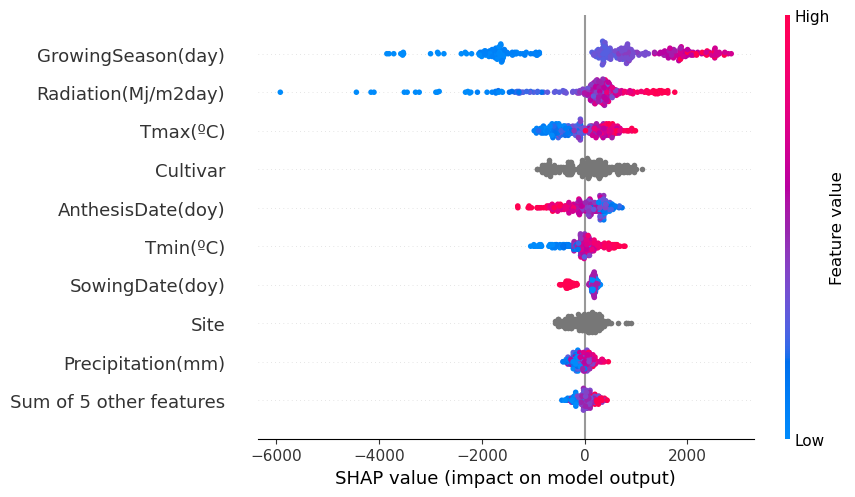

In [45]:
# 🔍 Calcular y visualizar SHAP values para XGBoost
explainer_xgb = shap.TreeExplainer(xgb_best)
shap_values_xgb = explainer_xgb(X_test)

# Gráfico resumen SHAP
shap.plots.beeswarm(shap_values_xgb)

###  💾 SAVING OPTIMIZED MODELS

In [47]:
import joblib

joblib.dump(lgb_best, "lgb_best_model.pkl")
joblib.dump(xgb_best, "xgb_best_model.pkl")
joblib.dump(rf_best, "rfr_best_model.pkl")

print("Succesfully exported models.")


Succesfully exported models.


In [48]:
try:
  lgb_best.booster_.save_model("DM_lgb_best_model.txt")
except Exception as e:
    print("❌ Error saving the model LightGBM:", e)

## PREDICTION

In [51]:
# 📦 Cargar modelos y realizar predicciones con nuevos datos
import joblib
try:
    lgb_loaded = joblib.load("lgb_best_model.pkl")
except Exception as e:
    print("❌ Error al cargar el modelo LightGBM:", e)
lgbm_loaded = joblib.load("lgb_best_model.pkl")
xgb_loaded = joblib.load("xgb_best_model.pkl")
rfr_loaded = joblib.load("rfr_best_model.pkl")

columnas = ['Site', 'Cultivar', 'Elevation(m)', 'Radiation(Mj/m2day)','Precipitation(mm)', 'Tmax(ºC)', 'Tmin(ºC)', 'WHC(mm)', 'C(%)', 'pH',
       'SowingDate(doy)', 'AnthesisDate(doy)', 'HarvestDate(doy)','GrowingSeason(day)']

datos = [['Barcia','A200',25,21,56.6,20.5,16.7,90,1.8999999999999997,5.200000000000003,133,228.70531400966183,250,117]]

print(len(columnas))
print(len(datos))

# Crear DataFrame
X_nuevos_datos = pd.DataFrame(datos, columns=columnas)
X_nuevos_datos["Site"] = X_nuevos_datos["Site"].astype("category")
X_nuevos_datos["Cultivar"] = X_nuevos_datos["Cultivar"].astype("category")

# Reemplazar X_nuevos_datos por datos reales
y_pred_lgb = lgb_loaded.predict(X_nuevos_datos)
y_pred_xgb = xgb_loaded.predict(X_nuevos_datos)
print(y_pred_lgb)
print(y_pred_xgb)

14
1
[15204.71972176]
[14907.668]


### Hamza / Anas CODE

[I 2025-08-15 23:29:01,145] A new study created in memory with name: MLP_kgCP/ha
[I 2025-08-15 23:29:05,726] Trial 0 finished with value: 75.76352345628739 and parameters: {'h1': 95, 'use_h2': 0, 'alpha': 2.134031790893451e-05, 'lr': 0.009422706907686972, 'activation': 'tanh', 'batch_size': 256}. Best is trial 0 with value: 75.76352345628739.
[I 2025-08-15 23:29:12,354] Trial 1 finished with value: 90.09970677351932 and parameters: {'h1': 53, 'use_h2': 1, 'h2': 19, 'alpha': 0.04106313595618689, 'lr': 0.0003221272225536493, 'activation': 'relu', 'batch_size': 128}. Best is trial 0 with value: 75.76352345628739.
[I 2025-08-15 23:29:17,074] Trial 2 finished with value: 51.9923565434035 and parameters: {'h1': 63, 'use_h2': 0, 'alpha': 0.07007921991257657, 'lr': 0.004719325080593052, 'activation': 'relu', 'batch_size': 128}. Best is trial 2 with value: 51.9923565434035.
[I 2025-08-15 23:29:23,959] Trial 3 finished with value: 974.4007213681074 and parameters: {'h1': 57, 'use_h2': 1, 'h2': 2


MLP (kgCP/ha)
R2:   0.9639
RMSE: 45.1721
MAE:  31.7996
MAPE: 3.31%


,feature,importance
25,num__kgDM/ha,512.912743
26,num__UFL/ha,306.439205
12,cat__Cultivar_G400,166.448056
11,cat__Cultivar_G300,157.872705
5,cat__Site_Sarria,141.902142
6,cat__Site_Villaviciosa,136.529729
4,cat__Site_Ribadeo,131.666753
21,num__SowingDate(doy),121.565245
0,cat__Site_Barcia,115.204824
7,cat__Cultivar_A200,104.602684


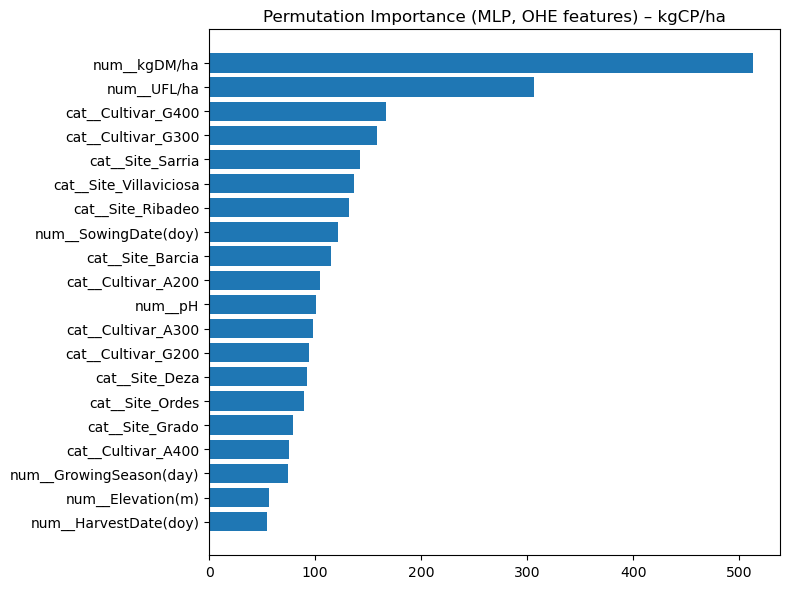

Saved: models/mlp_cp.pkl


In [58]:
import os, joblib, numpy as np, pandas as pd, optuna
from IPython.display import display
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

DATA_PATH = "260324_ENG_MaizeForageSpainNWwtYearRadDay.xlsx"
if 'df' not in globals():
    df = pd.read_excel(DATA_PATH)

objective_var = 'kgCP/ha'

cat_cols = [c for c in df.columns if c.lower() in ('site','cultivar')]
num_cols = [c for c in df.columns if c not in cat_cols + [objective_var]]

X = df[cat_cols + num_cols].copy()
y = df[objective_var].astype(float).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def preprocessor():
    try:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    return ColumnTransformer([('cat', ohe, cat_cols), ('num', StandardScaler(), num_cols)], remainder='drop')

def make_pipe(hidden=(128,64), alpha=1e-3, lr=1e-3, act='relu', batch=128):
    return Pipeline([('prep', preprocessor()),
                     ('model', MLPRegressor(hidden_layer_sizes=hidden, alpha=alpha,
                                            learning_rate_init=lr, activation=act,
                                            batch_size=batch, max_iter=1000, random_state=42))])

def objective(trial):
    h1 = trial.suggest_int('h1', 32, 256, log=True)
    use_h2 = trial.suggest_categorical('use_h2', [0,1])
    hidden = (h1,) if use_h2==0 else (h1, trial.suggest_int('h2', 16, 256, log=True))
    alpha = trial.suggest_float('alpha', 1e-6, 1e-1, log=True)
    lr    = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    act   = trial.suggest_categorical('activation', ['relu','tanh'])
    batch = trial.suggest_categorical('batch_size', [32,64,128,256])
    pipe  = make_pipe(hidden, alpha, lr, act, batch)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    s = cross_val_score(pipe, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1).mean()
    return -s

study = optuna.create_study(direction='minimize', study_name=f"MLP_{objective_var}")
study.optimize(objective, n_trials=40, show_progress_bar=False)
p = study.best_params
hidden = (p['h1'],) if p['use_h2']==0 else (p['h1'], p['h2'])

pipe = make_pipe(hidden, p['alpha'], p['lr'], p['activation'], p['batch_size'])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
mae = float(mean_absolute_error(y_test, y_pred))
mape = float(np.mean(np.abs((y_test - y_pred) / np.clip(y_test, 1e-9, None))) * 100)

print(f"\nMLP ({objective_var})")
print(f"R2:   {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

Xt_test = pipe.named_steps['prep'].transform(X_test)
est = pipe.named_steps['model']
pi = permutation_importance(est, Xt_test, y_test, n_repeats=10, random_state=42, scoring='neg_root_mean_squared_error')
feat_names = pipe.named_steps['prep'].get_feature_names_out()
imp_df = pd.DataFrame({'feature': feat_names, 'importance': pi.importances_mean}).sort_values('importance', ascending=False).head(20)
display(imp_df)

plt.figure(figsize=(8, 6))
plt.barh(imp_df['feature'][::-1], imp_df['importance'][::-1])
plt.title(f'Permutation Importance (MLP, OHE features) – {objective_var}')
plt.tight_layout()
plt.show()

os.makedirs('models', exist_ok=True)
short = {'kgDM/ha':'dm','UFL/ha':'ufl','kgCP/ha':'cp'}[objective_var]
out_path = f"models/mlp_{short}.pkl"
joblib.dump(pipe, out_path)
print(f"Saved: {out_path}")
